In [8]:
import svgwrite
import numpy as np
import matplotlib.pyplot as plt
import utils as U

from tip import Tip
from vine import Vine, ClothoidVine

%matplotlib inline

%load_ext autoreload
%autoreload 2



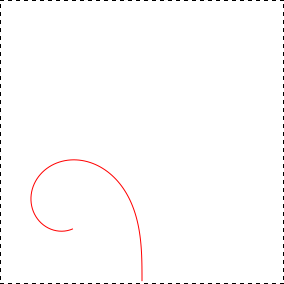

In [9]:
pos = np.array([0.5, 1])
path = U.clothoid(
    pos, 
    direction=[0, -1],
    v=0.01,
    rv=0,
    drv=6,
    length=1.0)

dwg = U.create_drawing()
U.draw_polyline(path, dwg)

# 枝の接続の検証

まず、1/3のところから生やす。後からゆらぎをもたせてみる。

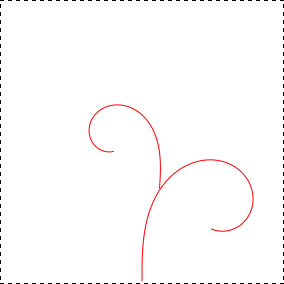

In [10]:
pos = np.array([0.5, 1])
path = U.clothoid(
    pos, 
    direction=[0, -1],
    v=0.01,
    rv=0,
    drv=-6,
    length=1.0)

parent = path
idx = len(parent)//3

pos = parent[idx]
v = np.diff(parent, axis=0)[idx]
v = U.rotate(v, 30)

child = U.clothoid(
    pos, 
    direction=v,
    v=0.01 * 2/3,
    rv=0,
    drv=6 * 3/2,
    length=1.0 * 2/3)

dwg = U.create_drawing()
U.draw_polyline(parent, dwg)
U.draw_polyline(child, dwg)

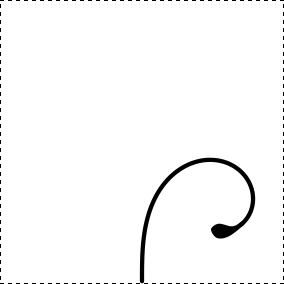

In [11]:
width = 0.015

tip, stem = Tip.split_bone_from_path(parent, width=width)

tip = Tip(tip, width=width)
dwg = tip.draw()
size = U.get_size_from_drawing(dwg)
U.draw_polyline(stem, dwg, stroke_width=size*width, stroke='black', stroke_linecap='round')

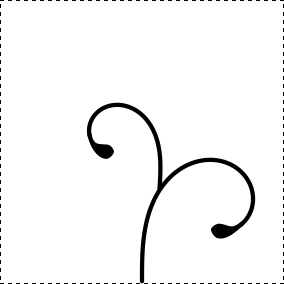

In [12]:
tip, stem = Tip.split_bone_from_path(child, width=width)

tip = Tip(tip, width=width)
dwg = tip.draw(dwg)
size = U.get_size_from_drawing(dwg)
U.draw_polyline(stem, dwg, stroke_width=size*width, stroke='black', stroke_linecap='round')

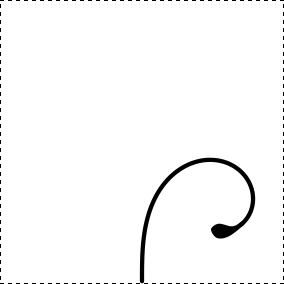

In [13]:
vine_parent = Vine(parent)
vine_parent.draw()

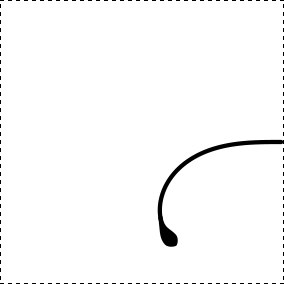

In [14]:
bone = U.clothoid_from_edge('right')
Vine(bone).draw()

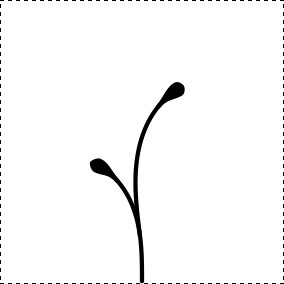

In [15]:
pos, direction = U.clothoid_params_from_edge('bottom')
vine = ClothoidVine(pos, direction)
vine.create_child(scale=1.2)
vine.draw()

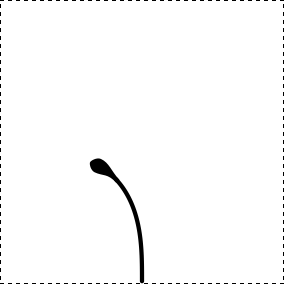

In [16]:
vine = ClothoidVine.from_edge('bottom')
vine.draw()

# 動的なパラメタ検証。これは面白い。

In [22]:
from ipywidgets import interact

def draw(rv=0, drv=6, length=0.5):
    vine = ClothoidVine.from_edge('bottom', rv=rv, drv=drv, length=length)
    return vine.draw()


interact(
    draw,
    rv=(-10, 10, 0.1),
    drv=(-20, 20, 0.1),
    length=(0.05, 2, 0.01)
)


interactive(children=(FloatSlider(value=0.0, description='rv', max=10.0, min=-10.0), FloatSlider(value=6.0, de…

<function __main__.draw(rv=0, drv=6, length=0.5)>

# 一旦寄り道として、他のエッジへの｢抜け｣を検証してみる

ベジェで繋ぐのがなんとなく良さそう。

(array([0. , 0.5]), array([1, 0]))

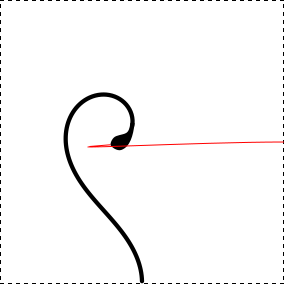

In [42]:
vine = ClothoidVine.from_edge('bottom', rv=2.80, drv=-9.70, length=1.10)
dwg = vine.draw()

pos, direction = U.vector_from_edge('right')
pos, direction

anchor_size = 0.3

direction = U.get_direction(direction) * anchor_size

size = U.get_size_from_drawing(dwg)
path = dwg.path(stroke_width=1, stroke='red', fill='none')

p = vine.bone[-1]
d = np.diff(vine.bone, axis=0)[-1]

d = U.get_direction(d) * anchor_size

path.push('M', p * size)
path.push('C', np.array([
    p + d, pos + direction, pos
]) * size)

dwg.add(path)
dwg

# ベジェで繋ぐのはだめだった。

ついでに、加速度の演算を試してみる。

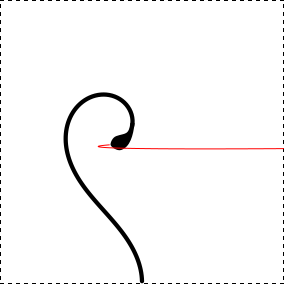

In [50]:
vine = ClothoidVine.from_edge('bottom', rv=2.80, drv=-9.70, length=1.10)
dwg = vine.draw()

pos, direction = U.vector_from_edge('right')
pos, direction

# anchor_size = 0.3

direction = U.get_direction(direction) * anchor_size

size = U.get_size_from_drawing(dwg)
path = dwg.path(stroke_width=1, stroke='red', fill='none')

p = vine.bone[-1]
d = np.diff(vine.bone, axis=0)[-1]

d = U.get_direction(d) * anchor_size
v = d * 0.01

path = []
while p[0] < 1:
    v[0] += 0.0001
    v[1] += (pos[1] - p[1]) * 0.0001
    p = p + v
    path.append(p)
    
path = np.array(path)    

dwg = U.draw_polyline(path, dwg)    

dwg

加速度も絶妙であった。  
そこで、方針を変える。下記のような実装により、｢抜け｣を実現できるはずである。  

1. 目標角度と鉛直になるまで、一定速度で方向転換
2. smoothstep的な曲線で辺とつなぐ。

-175.7420000000004


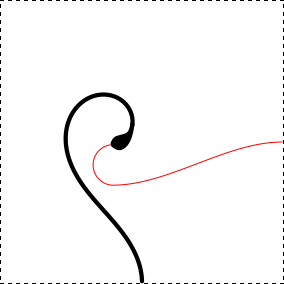

In [149]:
vine = ClothoidVine.from_edge('bottom', rv=2.80, drv=-9.70, length=1.10)
dwg = vine.draw()

pos, direction = U.vector_from_edge('right')
pos, direction

target_dir = -direction

size = U.get_size_from_drawing(dwg)

p = vine.bone[-1]
d = np.diff(vine.bone, axis=0)[-1]

speed = 0.01

v = U.get_direction(d) * speed
angle = U.get_angle(d, target_dir) * 180 / np.pi

print(angle)

dtheta = 8.0 * np.sign(angle)
path = [p]
for _ in range(int(np.abs(angle/dtheta))):
    v = U.rotate(v, -dtheta)
    p = p + v
    path.append(p)
    
u = target_dir * speed
v = U.norm(u)

dist = pos - p
steps = np.abs(np.inner(u, dist) / np.linalg.norm(u) ** 2)
steps = int(steps) + 1
vscale = np.inner(v, dist) / np.linalg.norm(v) ** 2

for i in range(steps):            
    path.append(p + u * i + v * vscale * U.smoothclamp(i, 0, steps-1))

    
path = np.array(path)
dwg = U.draw_polyline(path, dwg)    
dwg

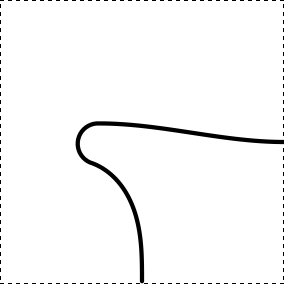

In [165]:
vine = ClothoidVine.from_edge('bottom')
vine.pass_to_edge("left")
dwg = vine.draw()
dwg

In [167]:
from ipywidgets import interact

def draw(rv=0, drv=6, length=0.5):
    vine = ClothoidVine.from_edge('bottom', rv=rv, drv=drv, length=length)
    vine.pass_to_edge("left")
    return vine.draw()


interact(
    draw,
    rv=(-10, 10, 0.1),
    drv=(-20, 20, 0.1),
    length=(0.05, 2, 0.01)
)


interactive(children=(FloatSlider(value=0.0, description='rv', max=10.0, min=-10.0), FloatSlider(value=6.0, de…

<function __main__.draw(rv=0, drv=6, length=0.5)>

# 一応つくってはみたものの、あまり美しくはない。

｢抜け｣は、クロソイドとは完全に違うアルゴリズムで作成するのが懸命か。